## Importation des modules nécessaires

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")


## Chargement des données

In [2]:
# Charger le jeu de données
data = pd.read_csv(r'../data/churn.csv')

## Exploration des données

In [3]:
# Afficher les premières lignes du jeu de données
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
data.shape

(7043, 21)

In [5]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [7]:
# Vérifier les valeurs manquantes
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## Visualisation

Text(0, 0.5, 'Count')

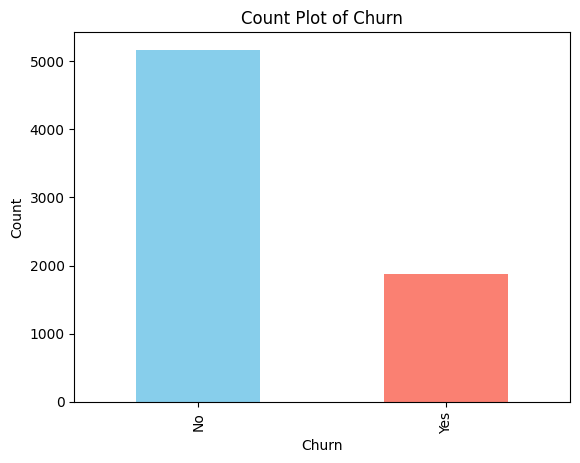

In [9]:
# Visualiser la distribution de l'attrition
fig, ax = plt.subplots()
data['Churn'].value_counts().plot(kind = 'bar', ax = ax, color = ['skyblue', 'salmon'])
ax.set_title('Count Plot of Churn')
ax.set_xlabel('Churn')
ax.set_ylabel('Count')


In [10]:
numRetained = data[data.Churn == 'No'].shape[0]
numChurned = data[data.Churn == 'Yes'].shape[0]

# Pourcentage de clients qui sont restés
print(numRetained/(numRetained + numChurned) * 100,"% sont restés.")
# Pourcentage de clients qui sont partis
print(numChurned/(numRetained + numChurned) * 100, "% sont partis.")

73.4630129206304 % sont restés.
26.536987079369588 % sont partis.


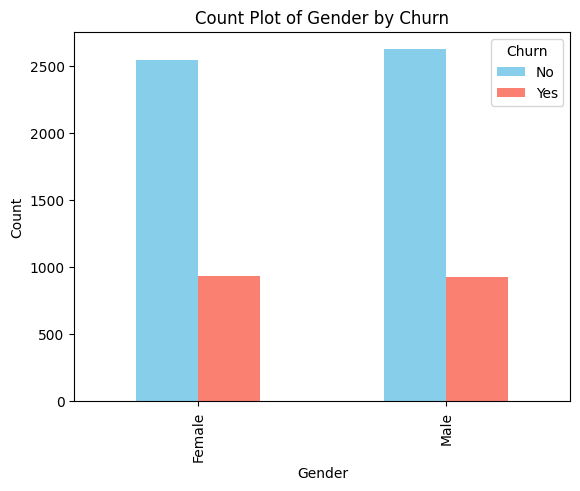

In [11]:
fig, ax = plt.subplots()
counts = data.groupby(['gender', 'Churn']).size().unstack()
counts.plot(kind = 'bar', ax = ax, color = ['skyblue', 'salmon'])
ax.set_title('Count Plot of Gender by Churn')
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.legend(title = 'Churn')


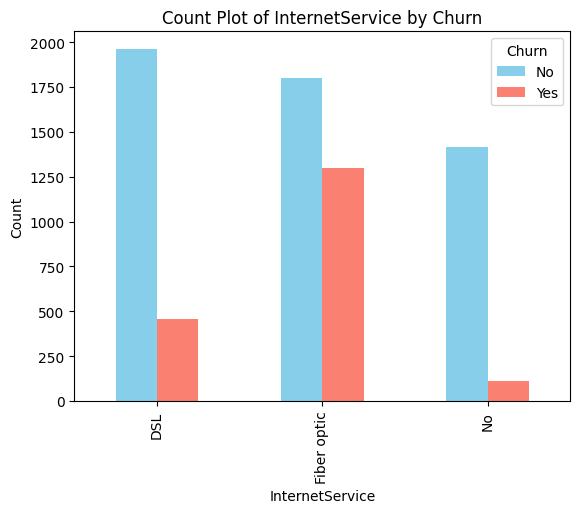

In [12]:
fig, ax = plt.subplots()
counts = data.groupby(['InternetService', 'Churn']).size().unstack()
counts.plot(kind='bar', ax = ax, color = ['skyblue', 'salmon'])
ax.set_title('Count Plot of InternetService by Churn')
ax.set_xlabel('InternetService')
ax.set_ylabel('Count')
ax.legend(title = 'Churn')


array([<Axes: title={'center': 'tenure'}>,
       <Axes: title={'center': 'MonthlyCharges'}>], dtype=object)

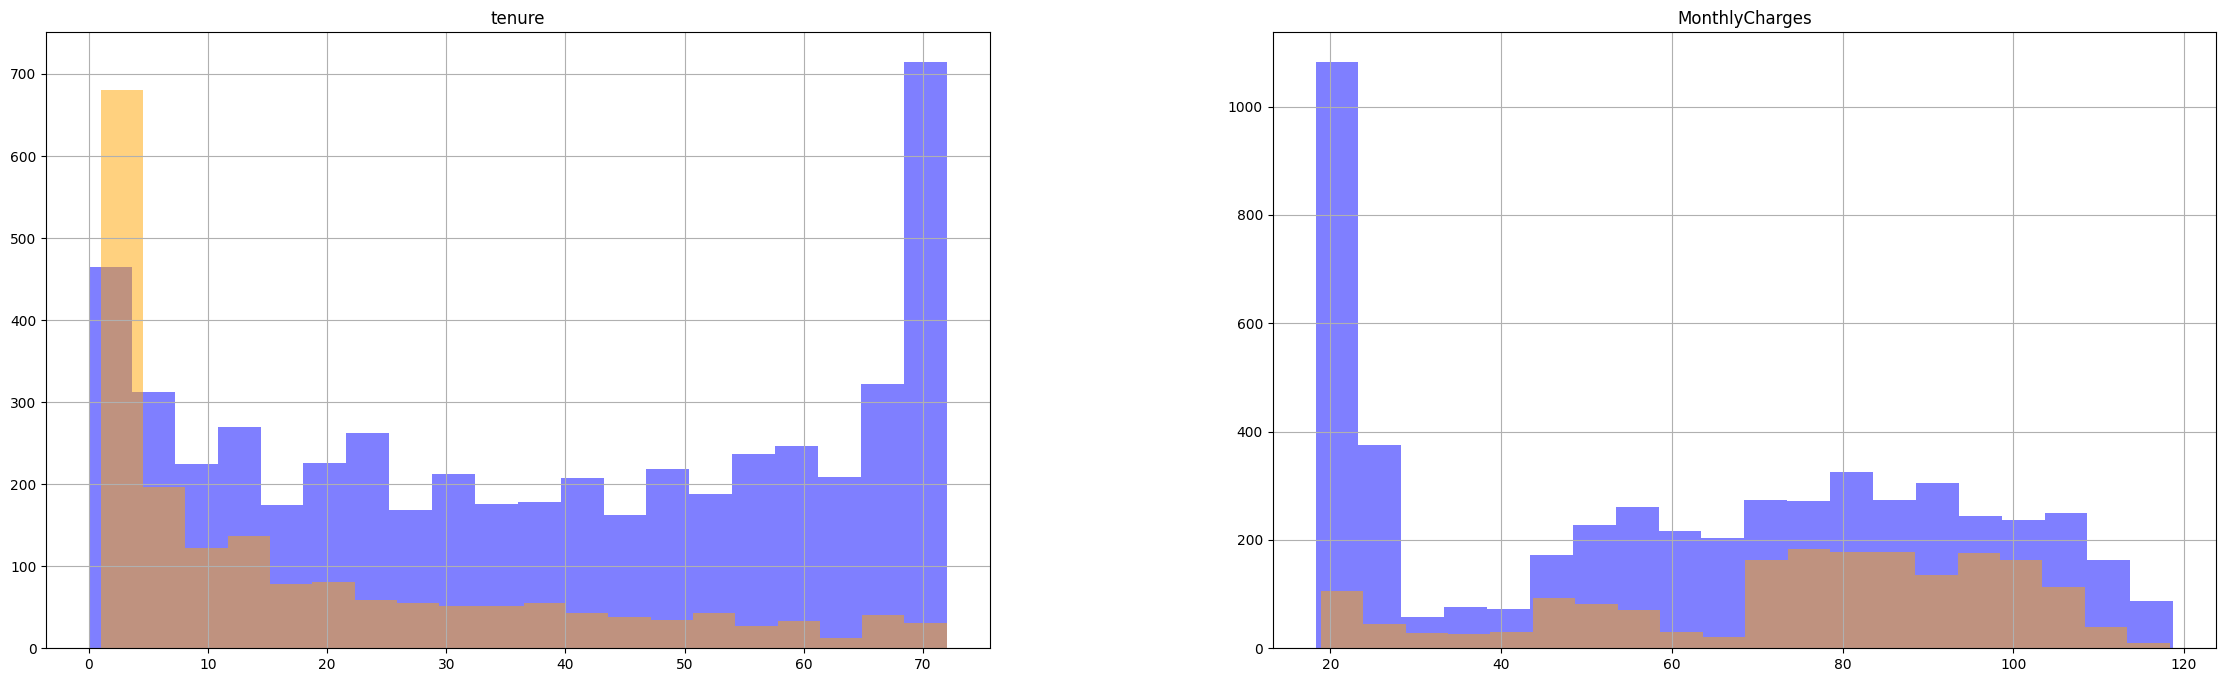

In [13]:
numericFeatures = ['tenure', 'MonthlyCharges']
fig, ax = plt.subplots(1, 2, figsize = (28, 8))
data[data.Churn == "No"][numericFeatures].hist(bins = 20, color = 'blue', alpha = 0.5, ax = ax)
data[data.Churn == "Yes"][numericFeatures].hist(bins = 20, color = 'orange', alpha = 0.5, ax = ax)

## Preprocessing

In [14]:
# Anonymisation des données
data = data.drop('customerID', axis = 1)

In [15]:
for column in data.columns:
  if data[column].dtype == np.number:
    continue
  data[column] = LabelEncoder().fit_transform(data[column])

In [16]:
data.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges          int64
Churn                 int64
dtype: object

In [17]:
# Isoler les ensembles
X = data.drop('Churn', axis = 1)
y = data['Churn']

# Standardisation des données
X = StandardScaler().fit_transform(X)

In [18]:
# Création des sous-ensembles d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Création et entrainement du modèle

In [19]:
# Initialiser et entraîner le modèle
model = LogisticRegression()

# Entrainement
model.fit(X_train, y_train)


LogisticRegression()

In [20]:
predictions = model.predict(X_test)

# print the predictions
print(predictions)

[1 0 0 ... 0 0 1]


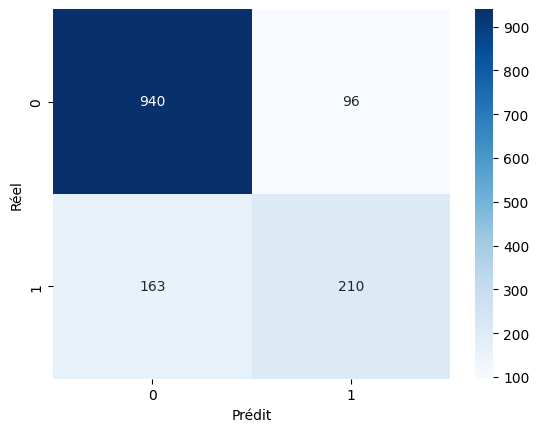

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.56      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



In [21]:
# Afficher la matrice de confusion
sns.heatmap(confusion_matrix(y_test, predictions), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

print(classification_report(y_test, predictions))

## Optimisation du modèle

In [22]:
# Définir les hyperparamètres à tester
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'l1', 'elasticnet', 'none']
}

# Initialiser la recherche par grille
grid_search = GridSearchCV(estimator = LogisticRegression(max_iter = 1000, random_state = 42), param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [23]:
# Afficher les meilleurs paramètres
print(grid_search.best_params_)

# Évaluer le modèle optimisé
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.57      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

